This data science project is based on a kaggle competition! Social media is undeniably the most important platform of communication in these times. It enables people to express their feelings, thoughts or opinions in real time. Hence news agencies and disaster relief organizations use social media in monitoring for potential emergency announcements for prompt responses. This notebook is focused on using natual language processing techniques on tweets and to build a machine learning model to classsify tweets that announce emergencies or disasters and those that do not.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

# Upgrade scikit-learn using pip
#!pip install --upgrade scikit-learn


import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
#drive.mount('/content/drive')

drive.mount("/content/drive", force_remount=True)

# Check for the file/folder paths
!ls "/content/drive/My Drive/Colab Notebooks/data/"

data_path = "/content/drive/My Drive/Colab Notebooks/data/"
train_data = pd.read_csv(data_path + "train.csv")
train_data.head()

Mounted at /content/drive
 anomaly.csv		    movies_metadata.csv		 sim_overview_db.mt	 train.csv
 cleaned_data.csv	    overview_db.df		 test.csv		 u.data
 daily_air_df_missing.csv  'Performance by Tactic.csv'	 tfidf_mat_cast.tf	 vectorizer_cast.tf
 db.csv			    ratings.csv			 tmdb_5000_credits.csv
 model.pkl		    recipes.csv			 tmdb_5000_movies.csv


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
train_data.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Dropping the id column since it is irrelevant to the model prediction, the location column since it has a lot of missing values and the keyword column since this insight can be derived from the text columns.

In [4]:
train_data.drop(columns = ['id','keyword','location'],inplace=True)
train_data.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


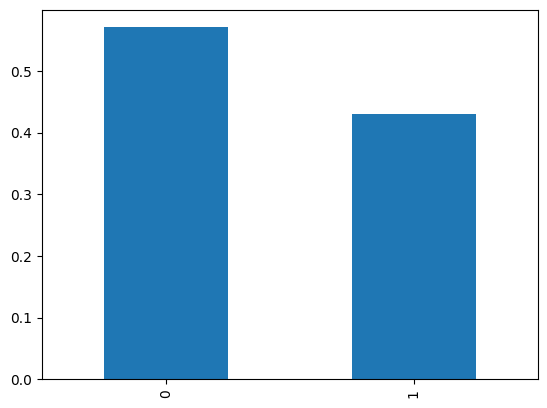

In [5]:
#Analysing Class Imbalance on the train data
train_data["target"].value_counts(normalize=True).plot(kind="bar")
plt.show()


Data doesn't seem to be highly skewed!

Splitting the data into independent and dependent variables:

In [6]:
from sklearn.model_selection import train_test_split

X = train_data['text']
y = train_data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

## Vectorization - Bag of Words

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

import nltk
stemmer = nltk.stem.PorterStemmer()
nltk.download('stopwords')
from nltk.corpus import stopwords

import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Defining a custom tokenizer:

In [8]:
stop_words = stopwords.words('english')
import re

def custom_tokenizer(document):
    #remove punctuation marks from document and set to lower case
    for punctuation in string.punctuation:
        document = document.replace(punctuation,"").replace('\n','').lower()

    #split document into tokens
    word_list = document.split(' ')
    new_word_list = []

    #remove alphanumeric and numeric characters
    for word in word_list:
        word = re.sub(r'\d+', '', word)
        if word != '' and word.isalnum():
            new_word_list.append(word)

    stemmedword_list = []

    # remove stopwords and any tokens that are just empty strings
    for word in new_word_list:
        if (not word in stop_words):
            #stemming
            stemmed_token = stemmer.stem(word)
            stemmedword_list.append(stemmed_token)

    return stemmedword_list

In [9]:
bagofwords = CountVectorizer(tokenizer=custom_tokenizer, min_df=2, ngram_range=(1, 2))

X_train_bow = bagofwords.fit_transform(X_train)
X_test_bow = bagofwords.transform(X_test)

X_train_bow.shape, X_test_bow.shape

((6090, 8665), (1523, 8665))

In [10]:
bagofwords.get_feature_names_out()

array(['aa', 'aba', 'aba woman', ..., 'å', 'åè', 'ìñ'], dtype=object)

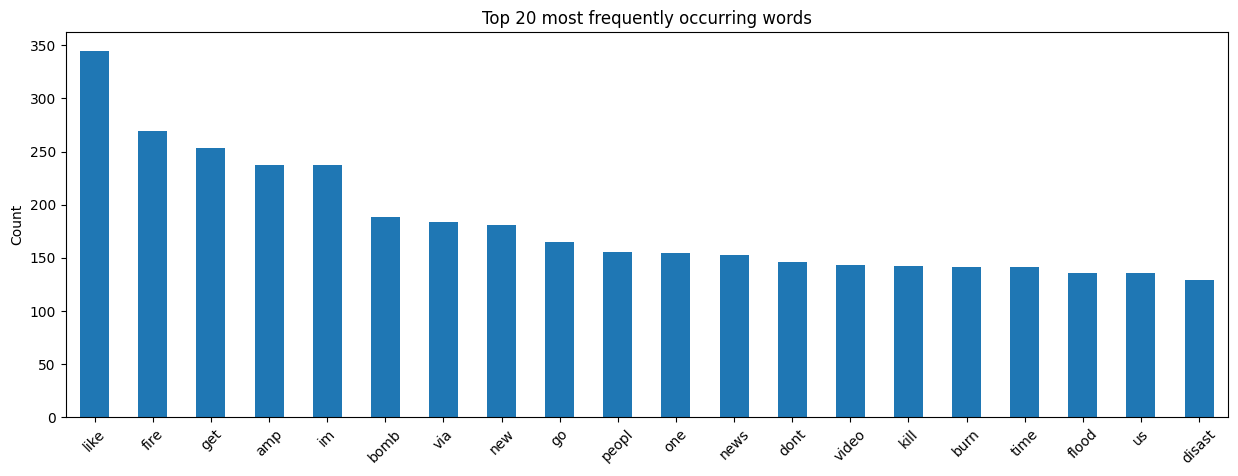

In [11]:
word_counts = pd.DataFrame(
    {"counts": X_train_bow.toarray().sum(axis=0)},
    index=bagofwords.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

### Using a Random Forest Classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from tempfile import mkdtemp
cachedir = mkdtemp()

estimators = [('rfc', RandomForestClassifier(random_state=42))]

pipe = Pipeline(estimators, memory = cachedir)

params = {'rfc__n_estimators': [30],
         'rfc__max_depth': [400,500,600],
         'rfc__min_samples_split': [2,4,7]}


grid_search = GridSearchCV(pipe, param_grid=params, scoring='f1')

fitted_search_rfc = grid_search.fit(X_train_bow, y_train)

#Evaluating on the f1 score
f1_trainscore = fitted_search_rfc.best_score_
print(f"F1 score on the train set: {f1_trainscore}")

F1 score on the train set: 0.7319326197642437


In [13]:
fitted_search_rfc.best_params_

{'rfc__max_depth': 500, 'rfc__min_samples_split': 7, 'rfc__n_estimators': 30}

In [14]:
from sklearn.metrics import f1_score

best_model_rfc = fitted_search_rfc.best_estimator_

y_pred = best_model_rfc.predict(X_test_bow)

f1_testscore = f1_score(y_test, y_pred)
print(f"F1 score on the test set: {f1_testscore}")

F1 score on the test set: 0.7323481116584565


In [15]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       870
           1       0.79      0.68      0.73       653

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.79      0.78      1523



## Vectorization - TF-IDF

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=custom_tokenizer, ngram_range=(1, 2))

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape

((6090, 56632), (1523, 56632))

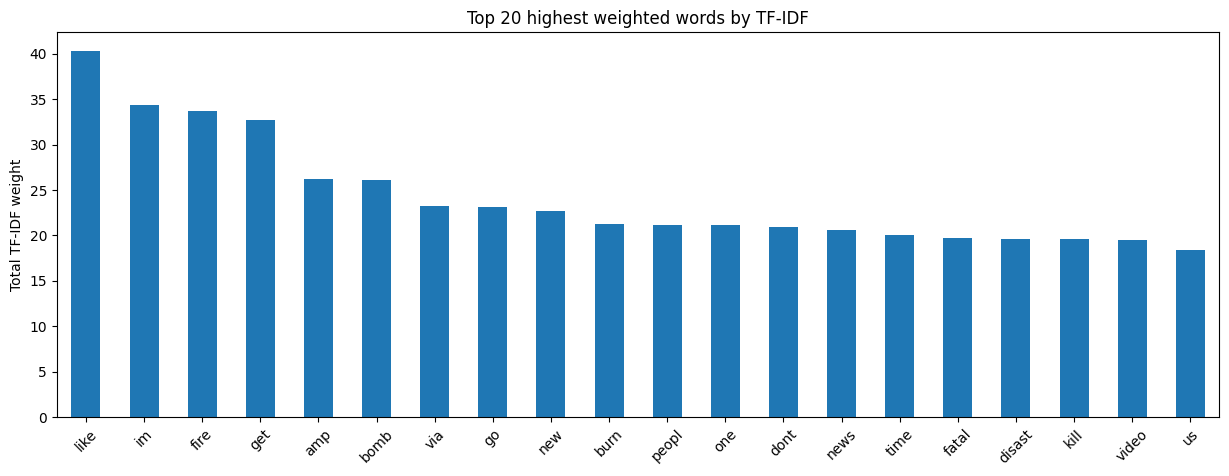

In [17]:
word_counts = pd.DataFrame(
    {"counts": X_train_tfidf.toarray().sum(axis=0)},
    index=tfidf.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 highest weighted words by TF-IDF")
plt.ylabel("Total TF-IDF weight")
plt.xticks(rotation=45)
plt.show()

In [18]:
estimators = [('rfc', RandomForestClassifier(random_state=42))]

pipe = Pipeline(estimators, memory = cachedir)

params = {'rfc__n_estimators': [30],
         'rfc__max_depth': [600,700,800],
         'rfc__min_samples_split': [2,4,7]}


grid_search = GridSearchCV(pipe, param_grid=params, scoring='f1')

fitted_search_rfc = grid_search.fit(X_train_tfidf, y_train)

#Evaluating on the f1 score
f1_trainscore = fitted_search_rfc.best_score_
print(f"F1 score on the train set: {f1_trainscore}")

F1 score on the train set: 0.7026394585127402


In [19]:
best_model_rfc = fitted_search_rfc.best_estimator_

y_pred = best_model_rfc.predict(X_test_tfidf)

f1_testscore = f1_score(y_test, y_pred)
print(f"F1 score on the test set: {f1_testscore}")

F1 score on the test set: 0.7319078947368421


In [20]:
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       870
           1       0.79      0.68      0.73       653

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.79      0.78      1523



In [21]:
fitted_search_rfc.best_params_

{'rfc__max_depth': 600, 'rfc__min_samples_split': 7, 'rfc__n_estimators': 30}

### XGBOOST
XGBoost based on the bag of words vectorization

In [22]:
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

estimators = [('xgb', XGBClassifier(random_state=42))]

pipe = Pipeline(estimators, memory = cachedir)

params = {'xgb__n_estimators': [30],
         'xgb__max_depth': [400,500,600],
         'xgb__min_samples_split': [2,5,7],
         'xgb__learning_rate':[0.001,0.01,0.1,1]}


grid_search = GridSearchCV(pipe, param_grid=params, scoring='f1')

fitted_search_xgb = grid_search.fit(X_train_bow, y_train)

#Evaluating on the f1 score
f1_trainscore = fitted_search_xgb.best_score_
print(f"F1 score on the train set: {f1_trainscore}")

F1 score on the train set: 0.7271357184984357


In [23]:
fitted_search_xgb.best_params_

{'xgb__learning_rate': 0.1,
 'xgb__max_depth': 400,
 'xgb__min_samples_split': 2,
 'xgb__n_estimators': 30}

In [24]:
best_model_xgb = fitted_search_xgb.best_estimator_

y_pred = best_model_xgb.predict(X_test_bow)

f1_testscore = f1_score(y_test, y_pred)
print(f"F1 score on the test set: {f1_testscore}")

F1 score on the test set: 0.7418831168831169


In [25]:
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       870
           1       0.79      0.70      0.74       653

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523

